<a href="https://colab.research.google.com/github/kazirafi17/CustomerSegmentation/blob/main/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name : Customer Segmentation

#### Description:

`Customer segmentation` simply means grouping your customers according to various characteristics (for example grouping customers by location).It’s a way for organizations to understand their customers. Knowing the differences between customer groups, it’s easier to make strategic decisions regarding product growth and marketing.

But, doing segmentation manually can be exhausting. Why not employ machine learning to do it for us? In this machine learning project, I’ll show you how to do just that. Stay tunned!




# 1. Import Libraries and framework

In [ ]:
# import required libraries for dataframe and visualization

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px

In [ ]:
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# 2. Load/Import and Read the datasets

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Online Retail.xlsx')


# 3. Data Cleaning and Preprocessing

#### 3.1 Explore the datasets

In [ ]:
df.head(5) # Display the first 5 rows of the DataFrame

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info() # Display information about the DataFrame, including the data types and non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.describe()  # Display summary statistics for numerical columns

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [ ]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

,0
InvoiceNo,0.00
StockCode,0.00
Description,0.27
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
CustomerID,24.93
Country,0.00


In [ ]:
df.nunique()  # Display the number of unique values in each column

,0
InvoiceNo,25900
StockCode,4070
Description,4223
Quantity,722
InvoiceDate,23260
UnitPrice,1630
CustomerID,4372
Country,38


In [ ]:
df.duplicated().sum() # Check for duplicate rows in the DataFrame and return a boolean Series

5268

#### Import insights:

*   0.27% and 25.16% of `Description` and `CustomerID` values are missing respectively.
*   Total 8 columns including 4 object, 2 floats, 1 int and 1 datetime. Dataset contains 5.4Lakhs rows.
*   It contains 5268 duplicated values.





#### 3.2 Handling Missing Values and Duplicats

In [ ]:
df.drop_duplicates(inplace=True) # Remove duplicate rows from the DataFrame

In [ ]:
df = df.dropna() # Droping rows having missing values

# 4. Feature Engineering

In [ ]:
# Create a new feature

df['Amount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
# Calculate sum of amount spend by each customers

df_amnt = df.groupby('CustomerID')['Amount'].sum().reset_index()
df_amnt.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
# Filter the DataFrame to include only the customers who have an 'Amount' less than 0
# This creates a new DataFrame containing customers who never bought anything or gave back products
df_non_buyers = df_amnt[df_amnt['Amount'] <= 0]

# Print the number of customers who didn't buy anything or gave back products
print(df_non_buyers.shape[0], "Number of customers didn't buy anything or gave back products. Samples are:")

# Filter the original DataFrame df to include only those customers whose CustomerID
# is present in the df_non_buyers DataFrame
df_filtered = df[df['CustomerID'].isin(df_non_buyers['CustomerID'])]

50 Number of customers didn't buy anything or gave back products. Samples are:


In [ ]:
# Customers that don't buy anything

df_filtered.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
343164,566938,22737,RIBBON REEL CHRISTMAS PRESENT,30,2011-09-15 15:48:00,1.65,14557.0,United Kingdom,49.50
62463,C541499,22325,MOBILE VINTAGE HEARTS,-3,2011-01-18 15:23:00,4.95,13693.0,United Kingdom,-14.85
3723,536663,22632,HAND WARMER RED RETROSPOT,24,2010-12-02 12:07:00,2.10,16546.0,United Kingdom,50.40
255446,C559347,22208,WOOD STAMP SET THANK YOU,-12,2011-07-07 17:22:00,0.83,18072.0,United Kingdom,-9.96
411729,C572228,22112,CHOCOLATE HOT WATER BOTTLE,-17,2011-10-21 14:03:00,4.25,15728.0,United Kingdom,-72.25



***Negative values*** in the Quantity column typically indicate returns or cancellations of products. When customers return items, the quantity is recorded as negative to reflect the subtraction from the total sales and inventory.Here's how it can be interpreted:



Same for the `Amount` column.

In [ ]:
df = df.drop(df_filtered.index)

In [ ]:
# Group the DataFrame 'df' by 'CustomerID' and count the unique 'InvoiceNo' values for each customer.
# This creates a DataFrame with 'CustomerID' and 'InvoiceNo' columns,
# where 'InvoiceNo' represents the count of unique invoices for each customer.
df_invc = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Rename the 'InvoiceNo' column to 'Frequency' to indicate the number of unique invoices for each customer.
df_invc.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Display the first few rows of the resulting DataFrame to verify the results.
df_invc.head()


,CustomerID,Frequency
0,12347.0,7
1,12348.0,4
2,12349.0,1
3,12350.0,1
4,12352.0,11


In [ ]:
# Convert to datetime to proper datatype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

# Compute the maximum date to know the last transaction date in our dataset
max_date = max(df['InvoiceDate'])

# Calculate the time difference between the maximum date in the dataset and the transaction date for each record
df['DaysSinceLastPurchase'] = max_date - df['InvoiceDate']

# Extract the days only from the time difference
df['DaysSinceLastPurchase'] = df['DaysSinceLastPurchase'].dt.days

# Group by CustomerID and calculate the minimum difference (Recency) for each customer
df_date = df.groupby('CustomerID')['DaysSinceLastPurchase'].min().reset_index()

# Display the first 5 rows of the resulting DataFrame
df_date.head()

,CustomerID,DaysSinceLastPurchase
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35


In [ ]:
# Merge df_amnt and df_invc on 'CustomerID'
df_merged1 = pd.merge(df_amnt, df_invc, on='CustomerID', how='inner')

# Merge the result with df_date on 'CustomerID'
df_final = pd.merge(df_merged1, df_date, on='CustomerID', how='inner')
df_final.head(5)

,CustomerID,Amount,Frequency,DaysSinceLastPurchase
0,12347.0,4310.00,7,1
1,12348.0,1797.24,4,74
2,12349.0,1757.55,1,18
3,12350.0,334.40,1,309
4,12352.0,1545.41,11,35


In [ ]:
# Calculate the total spending per visit for each customer by dividing the amount by frequency.
# The new column is named 'Avg_Spending_Per_Visit' to indicate average spending per visit.
# Round the result to two decimal places.
df_final['Avg_Spending_Per_Visit'] = (df_final['Amount'] / df_final['Frequency']).round(2)

# Display the first few rows of the DataFrame to verify the results.
df_final.head()

,CustomerID,Amount,Frequency,DaysSinceLastPurchase,Avg_Spending_Per_Visit
0,12347.0,4310.00,7,1,615.71
1,12348.0,1797.24,4,74,449.31
2,12349.0,1757.55,1,18,1757.55
3,12350.0,334.40,1,309,334.40
4,12352.0,1545.41,11,35,140.49


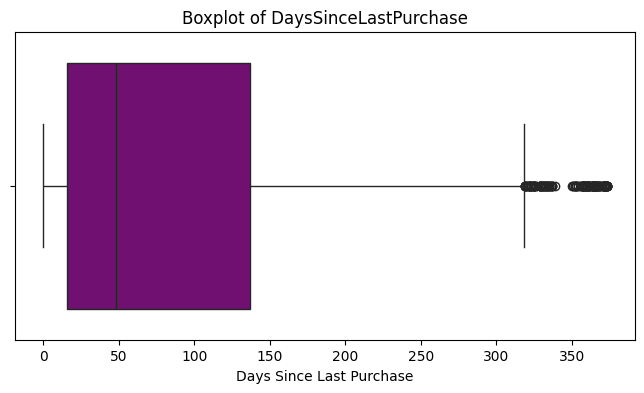

In [ ]:
# Create a boxplot for DaysSinceLastPurchase
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_final['DaysSinceLastPurchase'],color='purple')
plt.title('Boxplot of DaysSinceLastPurchase')
plt.xlabel('Days Since Last Purchase')
plt.show()

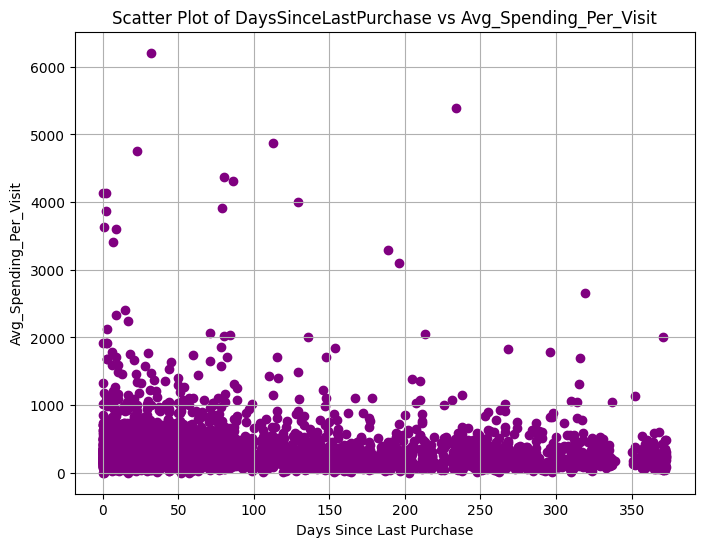

In [ ]:
# Create a scatter plot of DaysSinceLastPurchase vs Amount
plt.figure(figsize=(8, 6))
plt.scatter(df_final['DaysSinceLastPurchase'], df_final['Avg_Spending_Per_Visit'], color='purple')
plt.title('Scatter Plot of DaysSinceLastPurchase vs Avg_Spending_Per_Visit')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Avg_Spending_Per_Visit')
plt.grid(True)
plt.show()


# Handling outliers

In [ ]:
# Removing (statistical) outliers for DaysSinceLastPurchase
Q1 = df_final['DaysSinceLastPurchase'].quantile(0.05)
Q3 = df_final['DaysSinceLastPurchase'].quantile(0.80)
IQR = Q3 - Q1
df_final = df_final[(df_final['DaysSinceLastPurchase'] >= Q1 - 1.5 * IQR) & (df_final['DaysSinceLastPurchase'] <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Avg_Spending_Per_Visit
Q1 = df_final['Avg_Spending_Per_Visit'].quantile(0.05)
Q3 = df_final['Avg_Spending_Per_Visit'].quantile(0.95)  # Corrected to 95th percentile
IQR = Q3 - Q1
df_final = df_final[(df_final['Avg_Spending_Per_Visit'] >= Q1 - 1.5 * IQR) & (df_final['Avg_Spending_Per_Visit'] <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Amount
Q1 = df_final['Amount'].quantile(0.05)
Q3 = df_final['Amount'].quantile(0.95)  # Corrected to 95th percentile
IQR = Q3 - Q1
df_final = df_final[(df_final['Amount'] >= Q1 - 1.5 * IQR) & (df_final['Amount'] <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Frequency
Q1 = df_final['Frequency'].quantile(0.05)
Q3 = df_final['Frequency'].quantile(0.95)  # Corrected to 95th percentile
IQR = Q3 - Q1
df_final = df_final[(df_final['Frequency'] >= Q1 - 1.5 * IQR) & (df_final['Frequency'] <= Q3 + 1.5 * IQR)]


Scaling data before plotting ensures that the variables are on the same scale, making it easier to interpret the box plot, especially when variables have different units or ranges. Adjust the parameters and customization as per your specific data and visualization requirements.

In [ ]:

# Define attributes to plot
attributes = ['DaysSinceLastPurchase', 'Avg_Spending_Per_Visit']

# Perform standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_final[attributes])

# Convert scaled data back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=attributes)

# Create the box plot using Plotly Express
fig = px.box(df_scaled.melt(var_name='Attributes', value_name='Range'),
             y='Range', x='Attributes', points='outliers', boxmode='group',
             title="Outliers Variable Distribution (Scaled)",
             labels={'Attributes': 'Attributes', 'Range': 'Range'},
             color_discrete_sequence=['purple'],  # Ensure all elements are purple
             width=800, height=600)

# Update layout with axis titles
fig.update_layout(
    xaxis=dict(title="Attributes", title_font=dict(size=14)),
    yaxis=dict(title="Range (Standardized)", title_font=dict(size=14)),
    showlegend=False
)

# Show the plot
fig.show()

In [ ]:
df_scaled.head(3)

,DaysSinceLastPurchase,Avg_Spending_Per_Visit
0,-0.903088,1.457760
1,-0.167888,0.703945
2,-0.731877,6.630453


# Building the model:

The elbow score for k=1: is 8435.999999999987
The elbow score for k=2: is 5028.419950065748
The elbow score for k=3: is 2762.8613179972604
The elbow score for k=4: is 2071.5817438488975
The elbow score for k=5: is 1679.6481130735629
The elbow score for k=6: is 1407.7683571546154
The elbow score for k=7: is 1176.1268141486992
The elbow score for k=8: is 1068.1787013283517
The elbow score for k=9: is 943.9382288862388
The elbow score for k=10: is 842.7875249185614


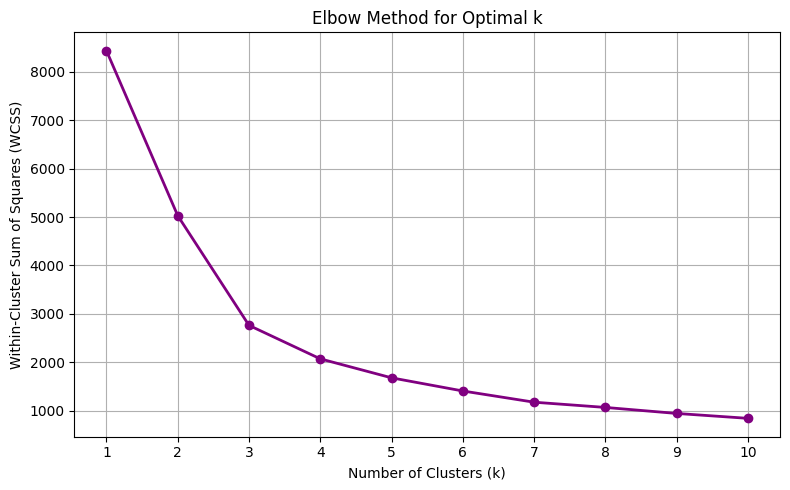

In [ ]:

# Define range of k values to test
k_values = range(1, 11)
wcss = []  # Within cluster sum of squares

# Calculate WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss_score = kmeans.inertia_
    wcss.append(wcss_score)
    print(f"The elbow score for k={k}: is {wcss_score}")

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='purple', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


For n_clusters=2, the silhouette score is 0.5054643904134708
For n_clusters=3, the silhouette score is 0.5512836145691788
For n_clusters=4, the silhouette score is 0.4560461844057647
For n_clusters=5, the silhouette score is 0.4397652992983202
For n_clusters=6, the silhouette score is 0.4041648159938652
For n_clusters=7, the silhouette score is 0.4275375836318474
For n_clusters=8, the silhouette score is 0.40697315322887295



*   I chose "4" as the number of clusters because it has the second-highest silhouette score (0.42349).
*    While the silhouette score for 2 clusters is slightly higher, the difference is not substantial.
*   And having 4 clusters may provide a more detailed and meaningful separation of your data





In [ ]:
# Final model with k=4
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [ ]:
kmeans.labels_

array([2, 1, 2, ..., 1, 1, 2], dtype=int32)

In [ ]:
# assign the label
df_final['Cluster_Id'] = kmeans.labels_
df_final.head()

,CustomerID,Amount,Frequency,DaysSinceLastPurchase,Avg_Spending_Per_Visit,Cluster_Id
0,12347.0,4310.00,7,1,615.71,2
1,12348.0,1797.24,4,74,449.31,1
2,12349.0,1757.55,1,18,1757.55,2
3,12350.0,334.40,1,309,334.40,0
4,12352.0,1545.41,11,35,140.49,1


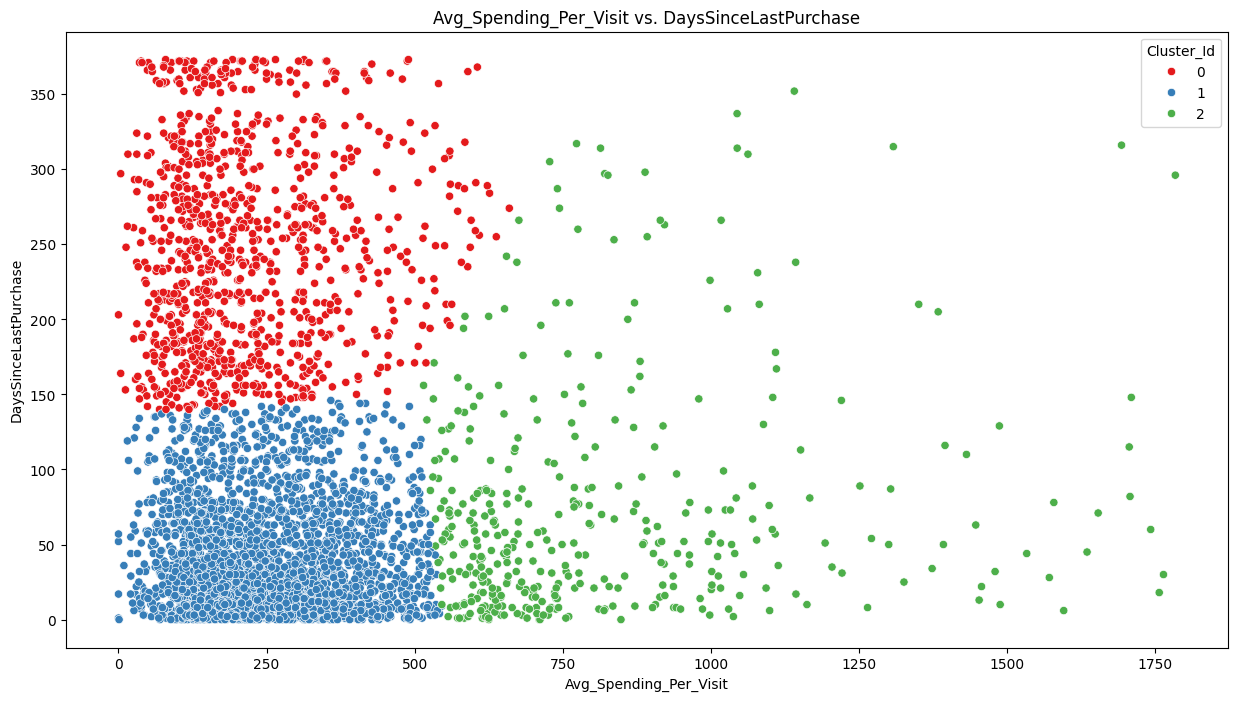

In [ ]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))  # Adjust the figure size here


# Amount vs. Frequency
sns.scatterplot(x='Avg_Spending_Per_Visit', y='DaysSinceLastPurchase', hue='Cluster_Id', data=df_final, palette='Set1')
plt.title('Avg_Spending_Per_Visit vs. DaysSinceLastPurchase')
plt.show()

In [ ]:
m = np.array([[800,300]])

# Scale the new data point using the same scaler
m_scaled = scaler.transform(m)

In [ ]:
kmeans.predict(m_scaled)

array([0], dtype=int32)

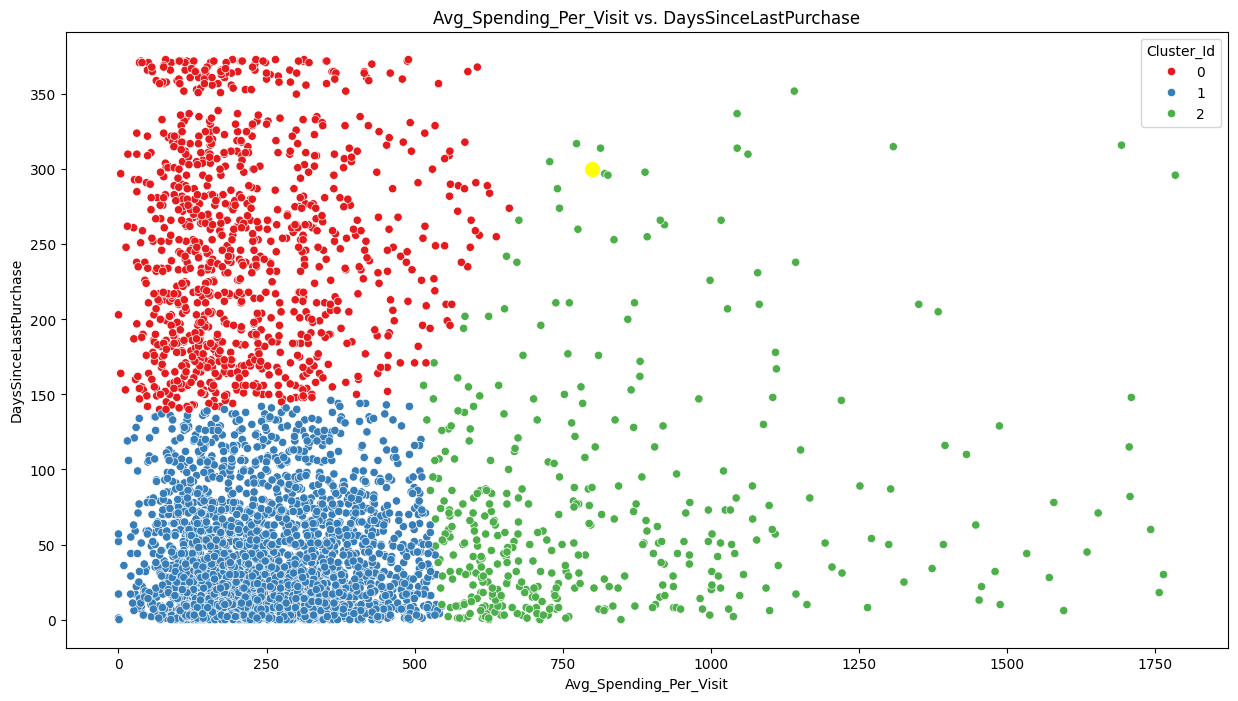

In [ ]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))  # Adjust the figure size here


# Amount vs. Frequency
sns.scatterplot(x='Avg_Spending_Per_Visit', y='DaysSinceLastPurchase', hue='Cluster_Id', data=df_final, palette='Set1')
# Draw the point (700, 300)
plt.scatter(800, 300, color='yellow', s=100, label='Point (100, 100)')
plt.title('Avg_Spending_Per_Visit vs. DaysSinceLastPurchase')
plt.show()

In [ ]:
fig = px.box(df_final, x='Cluster_Id', y='DaysSinceLastPurchase',
             title="Cluster Id vs DaysSinceLastPurchase Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'DaysSinceLastPurchase': 'DaysSinceLastPurchase'},
             color='Cluster_Id')

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="DaysSinceLastPurchase", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [ ]:
fig = px.scatter(df_final, x='Cluster_Id', y='Avg_Spending_Per_Visit', color='Frequency',
                 title='Cluster ID vs Avg_Spending_Per_Visit (Color Encoded by Frequency)',
                 labels={'Cluster_Id': 'Cluster ID', 'Avg_Spending_Per_Visit': 'Avg_Spending_Per_Visit', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="AmoAvg_Spending_Per_Visitunt", title_font=dict(size=14)),
    showlegend=True,
    width=800,
    height=600
)

fig.show()

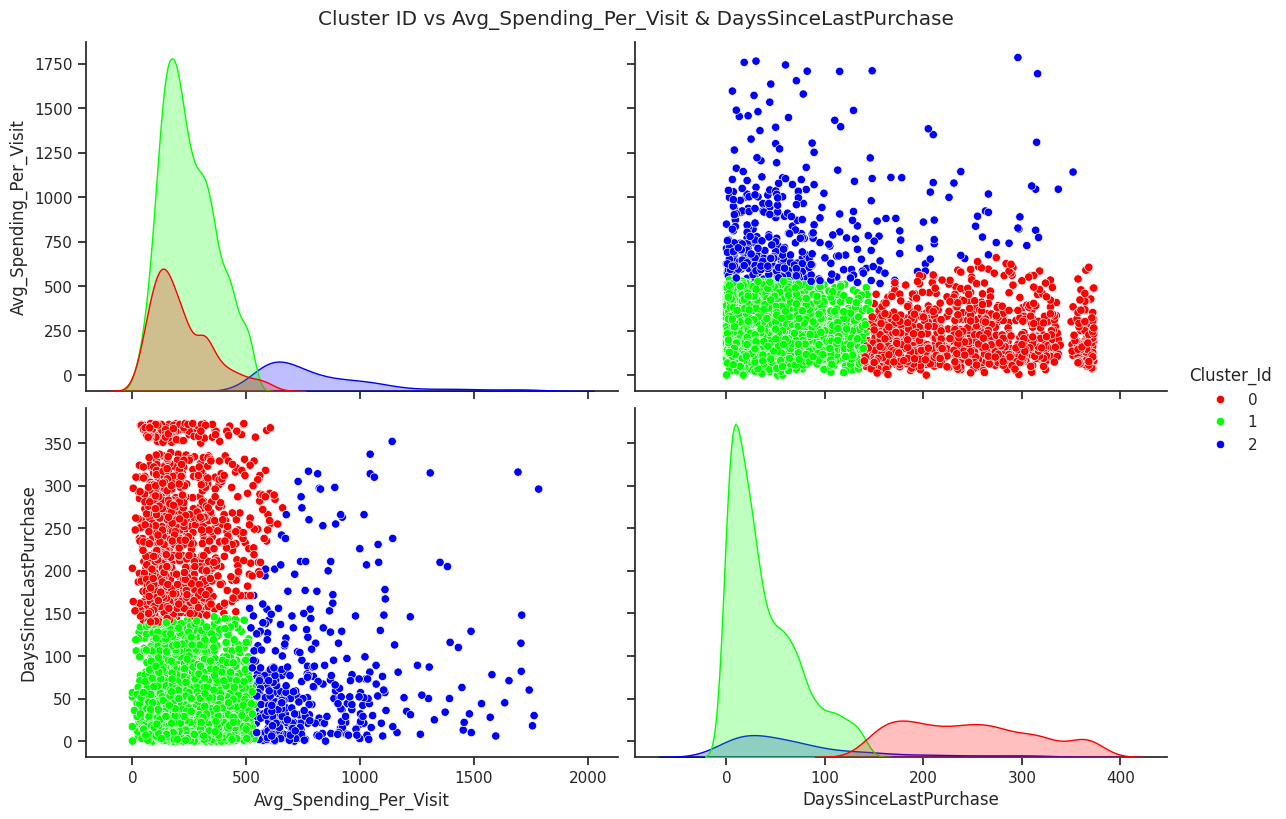

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom color palette with Red, Green, and Blue
custom_palette = sns.color_palette(["#FF0000", "#00FF00", "#0000FF"])

# Create a scatter plot matrix with separate plots for each cluster, custom palette, and a larger size
sns.set(style="ticks")
sns.pairplot(df_final, hue='Cluster_Id', vars=['Avg_Spending_Per_Visit', 'DaysSinceLastPurchase'], palette=custom_palette, height=4, aspect=1.5)
plt.suptitle('Cluster ID vs Avg_Spending_Per_Visit & DaysSinceLastPurchase', y=1.02)
plt.show()

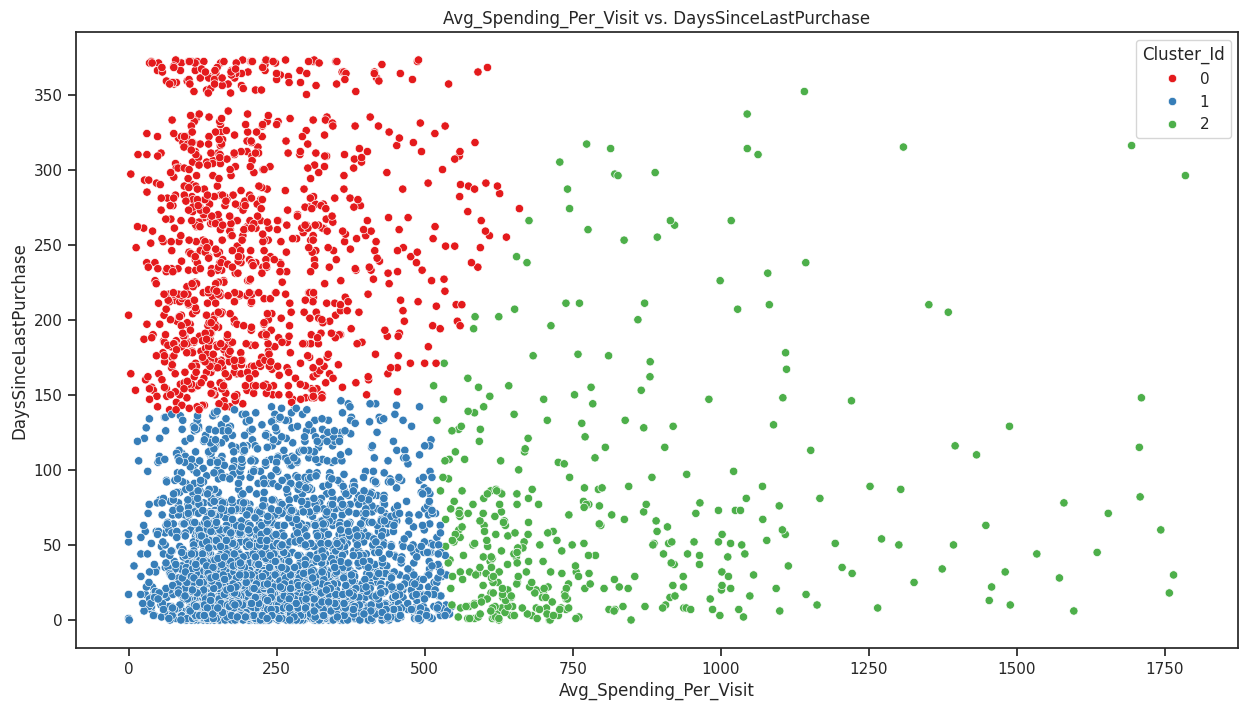

In [ ]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))  # Adjust the figure size here


# Amount vs. Frequency
sns.scatterplot(x='Avg_Spending_Per_Visit', y='DaysSinceLastPurchase', hue='Cluster_Id', data=df_final, palette='Set1')
plt.title('Avg_Spending_Per_Visit vs. DaysSinceLastPurchase')
plt.show()

In [ ]:
import plotly.express as px

df_final['Cluster_3D'] = kmeans.fit_predict(df_scaled2)

# Create a 3D scatter plot matrix with Plotly
fig = px.scatter_3d(df_final, x='Avg_Spending_Per_Visit', y='Frequency', z='DaysSinceLastPurchase', color='Cluster_3D',
                     labels={'Avg_Spending_Per_Visit': 'Avg_Spending_Per_Visit', 'Frequency': 'Frequency', 'DaysSinceLastPurchase': 'DaysSinceLastPurchase', 'Cluster_3D': 'Cluster'})

fig.update_layout(
    scene=dict(
        xaxis_title='Avg_Spending_Per_Visit',
        yaxis_title='Frequency',
        zaxis_title='DaysSinceLastPurchase',
    ),
    title='Clustering by Avg_Spending_Per_Visit, Frequency, and DaysSinceLastPurchase',
    width=800,
    height=600
)

fig.show()

NameError: name 'df_scaled2' is not defined

**Conclusion:**

It’s not wise to serve all customers with the same product model, email, text message campaign, or ad. Customers have different needs. A one-size-for-all approach to business will generally result in less engagement, lower-click through rates, and ultimately fewer sales. Customer segmentation is the cure for this problem.

Finding an optimal number of unique customer groups will help you understand how your customers differ, and help you give them exactly what they want. Customer segmentation improves customer experience and boosts company revenue. That’s why segmentation is a must if you want to surpass your competitors and get more customers. Doing it with machine learning is definitely the right way to go.

If you made it this far, thanks for your valuable time!

In [ ]:
df_scaled

,DaysSinceLastPurchase,Avg_Spending_Per_Visit
0,-0.903088,1.457760
1,-0.167888,0.703945
2,-0.731877,6.630453
3,2.198855,0.183387
4,-0.560666,-0.695052
...,...,...
4213,1.876575,-0.513348
4214,0.899664,-0.965365
4215,-0.842661,-1.064802
4216,-0.882946,-0.752313


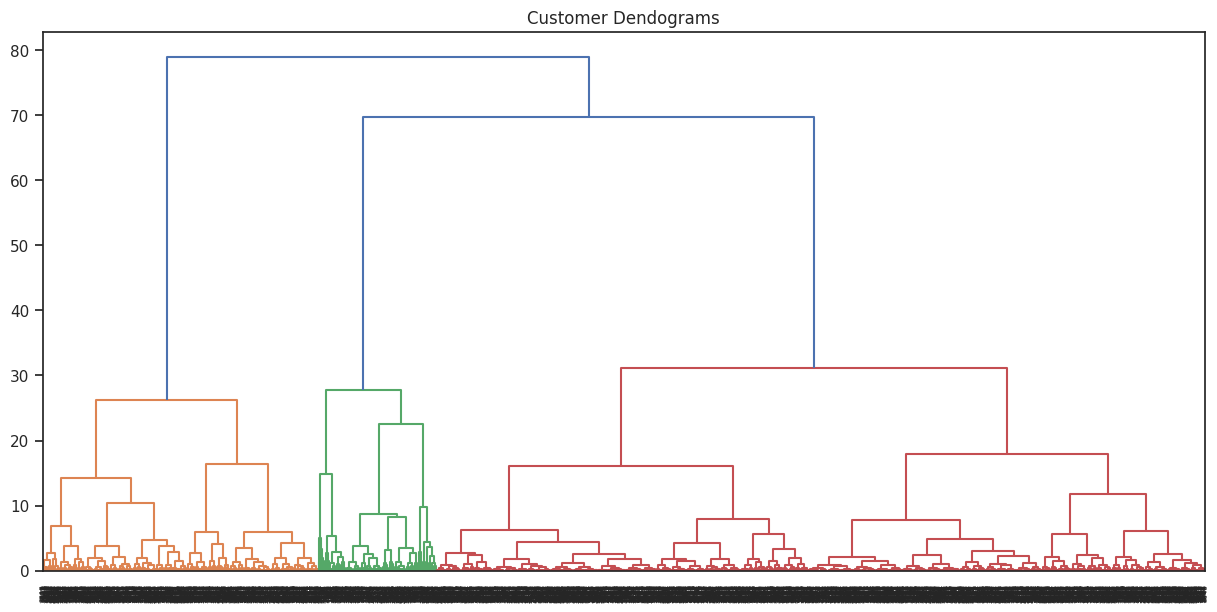

In [ ]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(15, 7))
plt.title("Customer Dendograms")
dend = sch.dendrogram(sch.linkage(df_scaled, method='ward'))

In [ ]:
# Import necessary libraries
from sklearn.cluster import AgglomerativeClustering

# Fit the AgglomerativeClustering model
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
Cluster_ID2 = cluster.fit_predict(df_scaled)

Cluster_ID2

array([0, 0, 0, ..., 2, 2, 0])

In [ ]:
# Add the NumPy array as a new column using assign method
df_scaled = df_scaled.assign(Cluster_ID2=Cluster_ID2)

In [ ]:
df_final['Cluster_ID2'] = Cluster_ID2

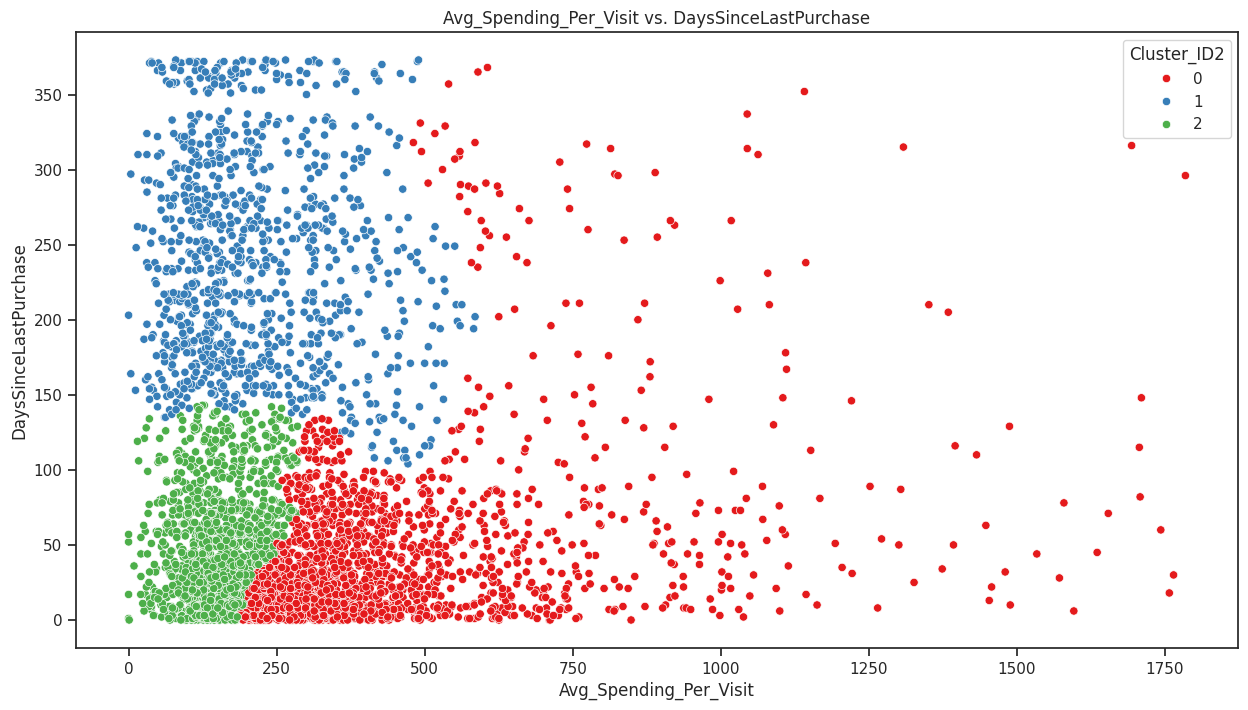

In [ ]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))  # Adjust the figure size here


# Amount vs. Frequencyzz
sns.scatterplot(x='Avg_Spending_Per_Visit', y='DaysSinceLastPurchase', hue='Cluster_ID2', data=df_final, palette='Set1')
plt.title('Avg_Spending_Per_Visit vs. DaysSinceLastPurchase')
plt.show()